# Import of the modules

In [ ]:
import aiohttp
import asyncio
import time
import json
import pandas as pd
from bs4 import BeautifulSoup
import lxml
import progressbar
from time import sleep
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

# Data reading and exportin to .csv file

In [237]:
async def get_item_data(session, url):
    async with session.get(url) as resp:
        site_data = await resp.read()
        return site_data   

async def main():
    
    with open(f'otomototabela.csv', 'w') as f:
        column_labels='auto'+'|cena'+'|rok_produkcji'+'|przebieg'+'|poj_silnika'+'|rodzaj_paliwa'+'\n'
        f.writelines(column_labels)
    ranges=[range(i*10+1,i*10+10) for i in range(10)] 
    brands=["audi","opel","kia","renault","peugeot","volkswagen","fiat","honda","hyundai","bmw","mercedes-benz","nissan","mazda","skoda"] 
    bar = progressbar.ProgressBar(maxval=len(ranges)).start()
    for brand in brands:
        for idx, seq in enumerate(ranges):
            bar.update(idx)
            async with aiohttp.ClientSession() as session:
                tasks = []
                for number in seq:
                    url = f'https://www.otomoto.pl/osobowe/{brand}?page={number}'
                    tasks.append(asyncio.ensure_future(get_item_data(session, url)))
                oto_moto_page = await asyncio.gather(*tasks)

                with open(f'otomototabela.csv', 'a') as f:
                    for page in oto_moto_page:
                        page=BeautifulSoup(page,features='html5')
                        for article in page.find_all('article'):
                            try:
                                list_of_param=article.find('ul', class_="e1p19lg712 e1p19lg720 ooa-1asrszr er34gjf0") 
                                f.writelines(article.div.h2.a.text+"|"+
                                             article.find_all('span', class_="ooa-1bmnxg7 e1p19lg711")[0].text+"|"+
                                             list_of_param.find_all('li', class_= "ooa-1k7nwcr e19ivbs0")[0].text+"|"+
                                             list_of_param.find_all('li', class_= "ooa-1k7nwcr e19ivbs0")[1].text+"|"+
                                             list_of_param.find_all('li', class_= "ooa-1k7nwcr e19ivbs0")[2].text+"|"+
                                             list_of_param.find_all('li', class_= "ooa-1k7nwcr e19ivbs0")[3].text+'\n')


                            except:
                                continue

start_time=time.time()
await main()
print("--- %s seconds ---" % (time.time() - start_time))

 90% (9 of 10) |######################   | Elapsed Time: 0:13:24 ETA:   0:12:46

--- 808.7217288017273 seconds ---


# Reading .csv file to data frame object

In [199]:
auta=pd.read_csv("otomototabela.csv",encoding = 'Windows-1252',sep="|",on_bad_lines='skip')

In [200]:
auta

,auto,cena,rok_produkcji,przebieg,poj_silnika,rodzaj_paliwa
0,Audi A4 40 TDI Advanced S tronic,121 900 PLN,2020,147 000 km,1 968 cm3,Diesel
1,Audi A6 Allroad 50 TDI mHEV Quattro Tiptr,325 000 PLN,2020,65 000 km,2 967 cm3,Diesel
2,Audi A6 Avant 2.0 TDI Ultra S tronic,81 999 PLN,2015,250 000 km,1 968 cm3,Diesel
3,Audi A3 2.0 TDI DPF Ambiente,16 000 PLN,2011,233 000 km,1 968 cm3,Diesel
4,Audi A8,610 000 PLN,2022,3 000 km,2 995 cm3,Hybryda
...,...,...,...,...,...,...
32323,Mazda CX-3 2.0 Skypassion,35 900 PLN,2019,10 245 km,1 998 cm3,Benzyna
32324,Mazda CX-9 3.7 V6 Limitowana edycja,107 000 PLN,2017,119 000 km,3 726 cm3,Benzyna
32325,Mazda CX-3 2.0 Skypassion,77 999 PLN,2018,50 000 km,1 998 cm3,Benzyna
32326,Mazda 3 1.6 CD Comfort,6 300 PLN,2006,332 689 km,1 560 cm3,Diesel


In [201]:
auta.drop_duplicates(['auto', 'przebieg','cena'],inplace=True)

# Data preparation for anlaysis

In [203]:
auta['Marka'] = auta['auto'].str.split(' ', 1, expand=True)[0]

In [205]:
auta['wersja'] = auta['auto'].str.split(' ', 2, expand=True)[1]

In [206]:
filterseries= auta['wersja']=="Seria"

In [207]:
auta.where(filterseries).dropna()['wersja'].unique()

array(['Seria'], dtype=object)

In [208]:
auta.loc[filterseries,'wersja']=auta['auto'].str.split(' ', 4, expand=True)[1]+" "+auta['auto'].str.split(' ', 4, expand=True)[2]

In [209]:
auta.where(filterseries).dropna()

,auto,cena,rok_produkcji,przebieg,poj_silnika,rodzaj_paliwa,Marka,wersja
22742,BMW Seria 3 318i Sport Line,179 950 PLN,2022.0,1 812 km,1 998 cm3,Benzyna,BMW,Seria 3
22744,BMW Seria 3 318i,11 200 PLN,2002.0,215 000 km,1 995 cm3,Benzyna,BMW,Seria 3
22745,BMW Seria 3 318d,26 900 PLN,2007.0,330 000 km,1 995 cm3,Diesel,BMW,Seria 3
22746,BMW Seria 3 320d Touring,68 900 PLN,2014.0,255 000 km,1 995 cm3,Diesel,BMW,Seria 3
22747,BMW Seria 5 520d Sport Line,129 999 PLN,2017.0,98 000 km,1 995 cm3,Diesel,BMW,Seria 5
...,...,...,...,...,...,...,...,...
27081,BMW Seria 5 530d xDrive Sport-Aut,84 600 PLN,2013.0,286 514 km,2 993 cm3,Diesel,BMW,Seria 5
27087,BMW Seria 4 428i,83 900 PLN,2015.0,165 000 km,1 997 cm3,Benzyna,BMW,Seria 4
27089,BMW Seria 1 125i Advantage,58 000 PLN,2012.0,142 000 km,1 997 cm3,Benzyna,BMW,Seria 1
31912,Mazda Seria B,20 500 PLN,2001.0,425 000 km,2 499 cm3,Diesel,Mazda,Seria B


# BWM models market analysis (pie plot %)

In [281]:
filterbmw= auta['Marka']=="BMW"
filterbmwmorethan1perc=auta.where(filterbmw).dropna()['wersja'].value_counts(normalize=True)>=0.01

In [285]:
bmwmdoelschart=auta.where(filterbmw).dropna()['wersja'].value_counts(normalize=True).where(filterbmwmorethan1perc).dropna()


<AxesSubplot:ylabel='wersja'>

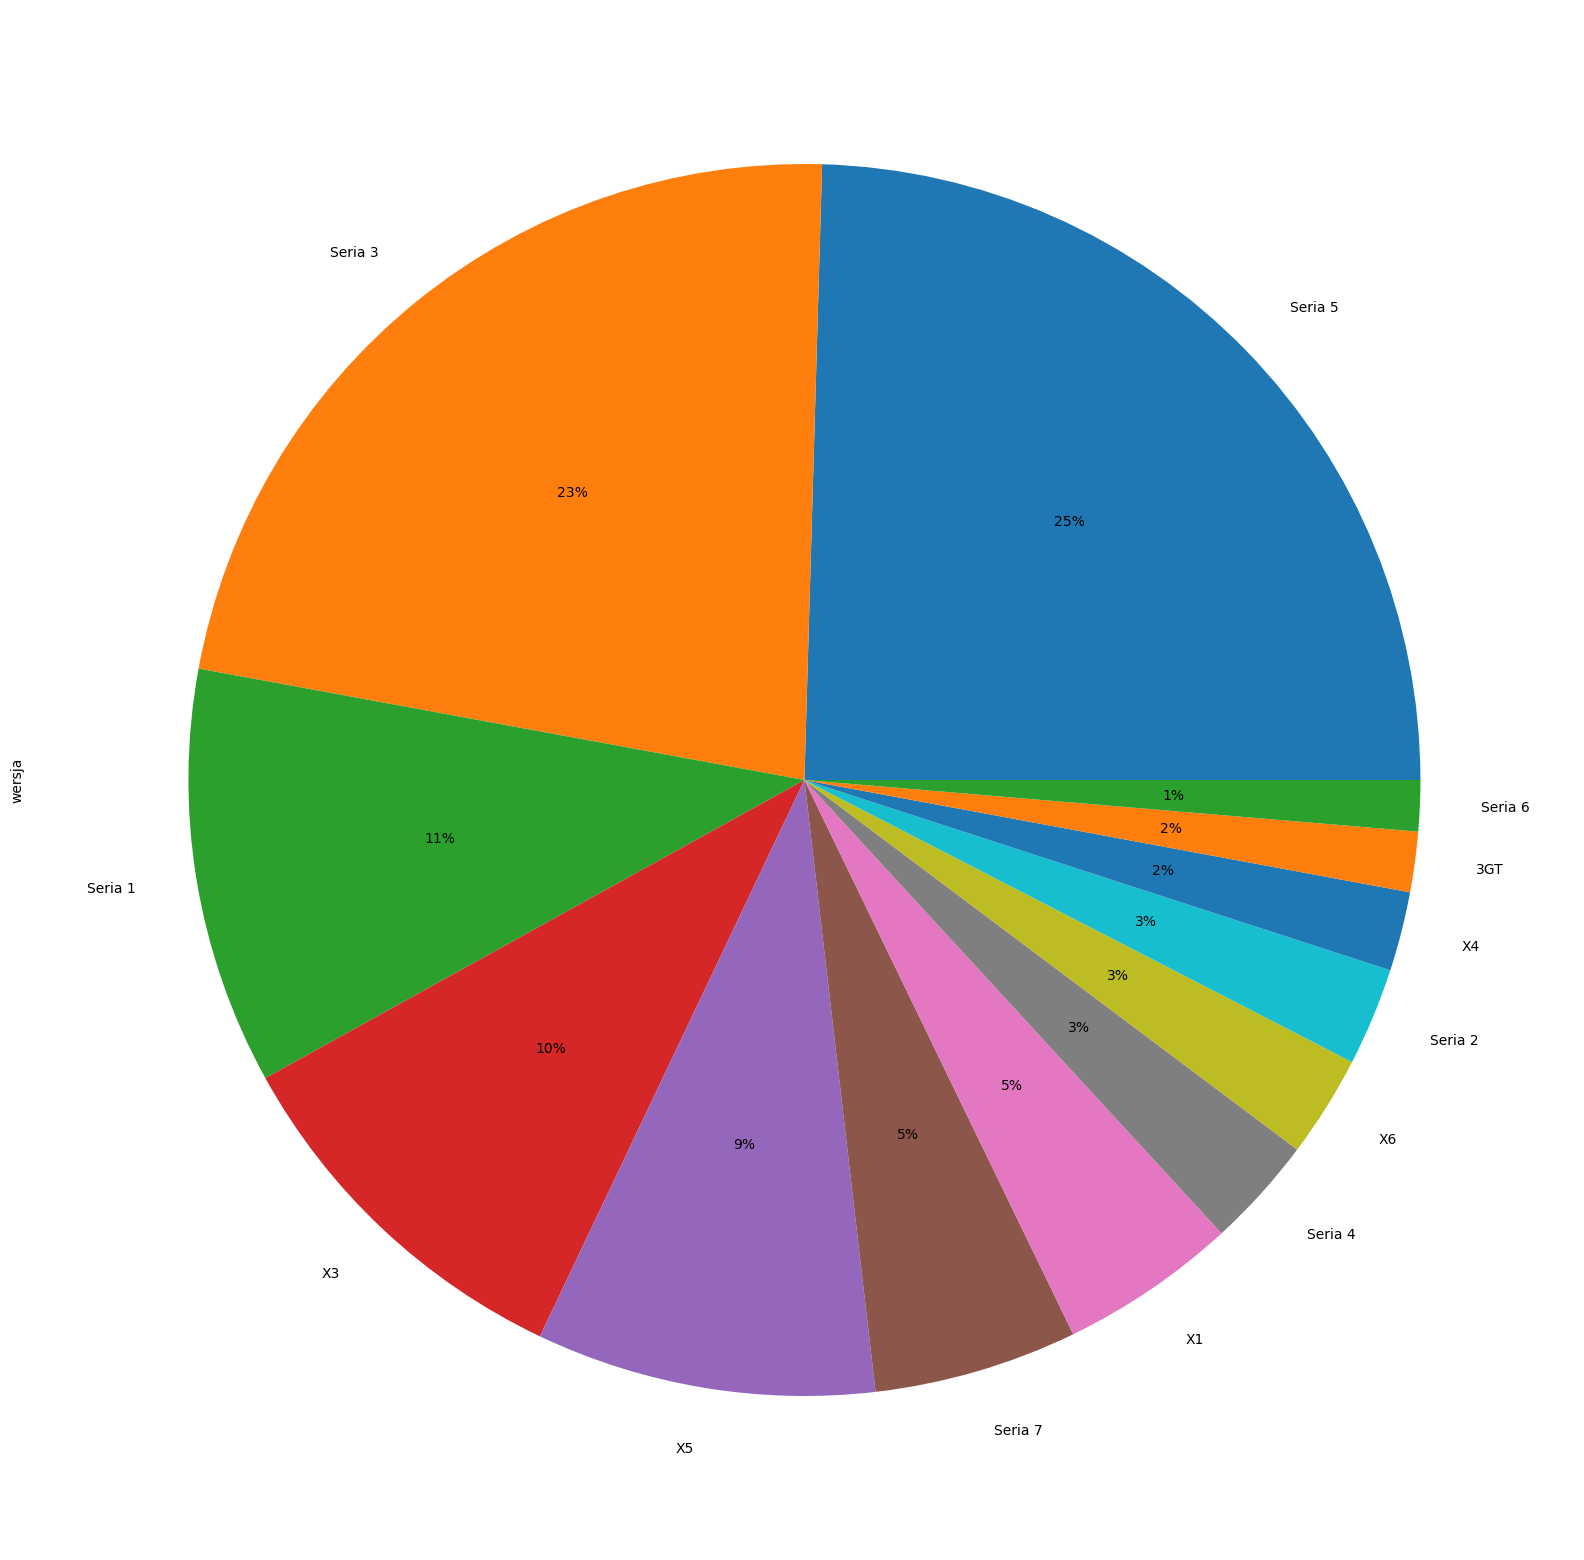

In [286]:
bmwmdoelschart.plot(kind='pie',figsize=[20,20],
                   subplots=False,layout=(1,1), legend=False,autopct="%.0f%%", textprops={'color':'black'})

# Opel models market analysis (pie plot %)

In [287]:
filteropel= auta['Marka']=="Opel"
filteropelmorethan1perc=auta.where(filteropel).dropna()['wersja'].value_counts(normalize=True)>=0.01

In [288]:
opelmdoelschart=auta.where(filteropel).dropna()['wersja'].value_counts(normalize=True).where(filteropelmorethan1perc).dropna()


<AxesSubplot:ylabel='wersja'>

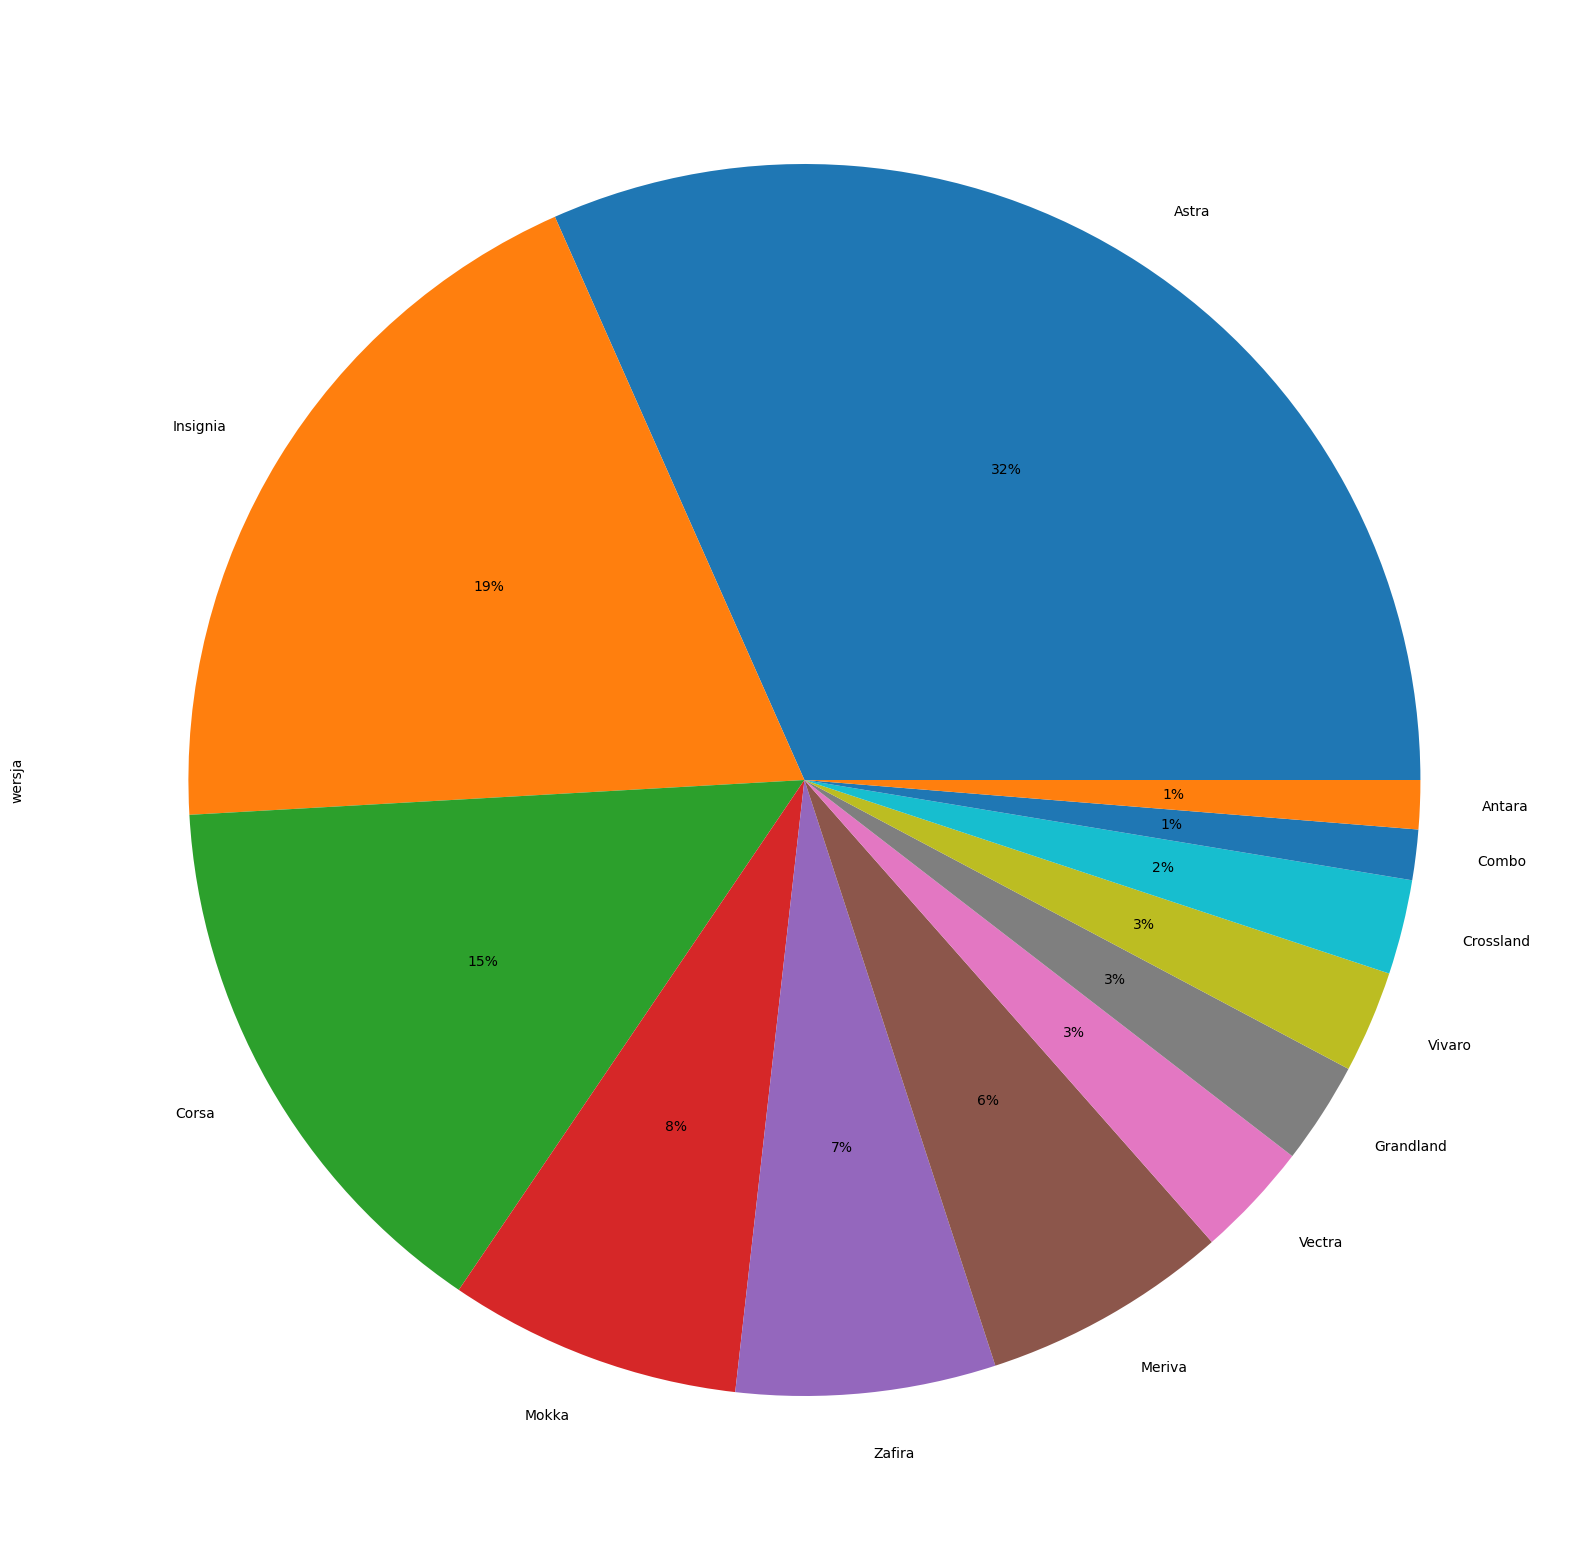

In [289]:
opelmdoelschart.plot(kind='pie',figsize=[20,20],
                   subplots=False,layout=(1,1), legend=False,autopct="%.0f%%", textprops={'color':'black'})

# Skoda models market analysis (Table %)

In [214]:
filterskoda= auta['Marka']=="Skoda"

In [259]:
auta.where(filterskoda).dropna()['wersja'].value_counts(normalize=True)

Octavia     0.458333
Superb      0.218750
Kodiaq      0.093750
Fabia       0.062500
Yeti        0.031250
RAPID       0.031250
Roomster    0.020833
Scala       0.020833
Karoq       0.020833
Kamiq       0.020833
Felicia     0.010417
Citigo      0.010417
Name: wersja, dtype: float64

# Audi models market analysis (Table %)

In [216]:
filteraudi= auta['Marka']=="Audi"

In [260]:
auta.where(filteraudi).dropna()['wersja'].value_counts(normalize=True)

A4           0.278492
A6           0.200580
A3           0.120597
Q5           0.086200
A5           0.076668
Q7           0.036055
Q3           0.033568
A7           0.022793
A8           0.022793
A1           0.013676
S3           0.012847
S5           0.009532
TT           0.009117
Q8           0.008288
RS3          0.007874
SQ7          0.007874
Q2           0.007460
SQ5          0.006216
RS           0.005802
S4           0.004973
80           0.004559
RS4          0.003730
RS6          0.003315
RS5          0.002487
SQ8          0.002487
S8           0.002487
S6           0.002487
S7           0.002072
A2           0.001243
RS7          0.001243
Cabriolet    0.000829
R8           0.000414
S1           0.000414
100          0.000414
Coupe        0.000414
Name: wersja, dtype: float64

# Kia models market analysis (Table %)

In [218]:
filterkia= auta['Marka']=="Kia"

In [261]:
auta.where(filterkia).dropna()['wersja'].value_counts(normalize=True)

Sportage     0.295075
Ceed         0.231583
Rio          0.069190
XCeed        0.060236
Venga        0.050468
Sorento      0.044770
Picanto      0.043956
Optima       0.042328
Stonic       0.033374
Carens       0.025641
Pro_cee'd    0.025234
Stinger      0.022385
Soul         0.020350
Niro         0.020350
Carnival     0.006105
Magentis     0.004070
Cerato       0.002442
Opirus       0.000814
Sedona       0.000814
Shuma        0.000407
Joice        0.000407
Name: wersja, dtype: float64

# VW models market analysis (Table %)

In [220]:
filtervw= auta['Marka']=="Volkswagen"

In [262]:
auta.where(filtervw).dropna()['wersja'].value_counts(normalize=True)

Golf           0.255698
Passat         0.202238
Tiguan         0.111065
Polo           0.072524
Touran         0.060506
T-Roc          0.036055
Caddy          0.033154
Arteon         0.024865
Sharan         0.024036
Touareg        0.021136
Transporter    0.020721
up!            0.016991
T-Cross        0.015334
Jetta          0.014919
Multivan       0.012847
Caravelle      0.012018
CC             0.009946
Scirocco       0.008703
Amarok         0.007874
California     0.004559
Crafter        0.004144
Taigo          0.003730
Eos            0.003730
New            0.003730
Fox            0.003730
Lupo           0.002901
Beetle         0.002901
Phaeton        0.002487
Bora           0.002487
Atlas          0.002072
Garbus         0.001658
Vento          0.000829
Corrado        0.000414
Name: wersja, dtype: float64

# Renault models market analysis (Table %)

In [222]:
filterrenault= auta['Marka']=="Renault"

In [263]:
auta.where(filterrenault).dropna()['wersja'].value_counts(normalize=True)

Megane      0.218105
Clio        0.188694
Scenic      0.089381
Captur      0.079450
Laguna      0.076394
Kadjar      0.055386
Grand       0.040107
Trafic      0.037433
Talisman    0.033613
Arkana      0.033613
Koleos      0.031704
Espace      0.029030
Kangoo      0.023300
Twingo      0.019862
Modus       0.014515
Master      0.009549
Fluence     0.005730
Thalia      0.003820
Vel         0.002674
Latitude    0.002292
Austral     0.001910
Express     0.000764
Avantime    0.000764
10          0.000382
Alaskan     0.000382
5           0.000382
19          0.000382
Safrane     0.000382
Name: wersja, dtype: float64

# Adding common price unit PLN, conversion prices EUR/PLN to PLN INT

In [225]:
auta.drop(['auto'], axis=1,inplace=True)

In [227]:
columns_titles = ["Marka","wersja","cena","rok_produkcji","przebieg","poj_silnika","rodzaj_paliwa"]
auta=auta.reindex(columns=columns_titles)

In [228]:
auta['cena_int'] = auta['cena'].apply(lambda x: int(x.split('PLN')[0].replace(' ', '')) if 'PLN' in x else 4.5*int(x.split('EUR')[0].replace(' ', '')))

In [229]:
auta

,Marka,wersja,cena,rok_produkcji,przebieg,poj_silnika,rodzaj_paliwa,cena_int
0,Audi,A4,121 900 PLN,2020,147 000 km,1 968 cm3,Diesel,121900.0
1,Audi,A6,325 000 PLN,2020,65 000 km,2 967 cm3,Diesel,325000.0
2,Audi,A6,81 999 PLN,2015,250 000 km,1 968 cm3,Diesel,81999.0
3,Audi,A3,16 000 PLN,2011,233 000 km,1 968 cm3,Diesel,16000.0
4,Audi,A8,610 000 PLN,2022,3 000 km,2 995 cm3,Hybryda,610000.0
...,...,...,...,...,...,...,...,...
32323,Mazda,CX-3,35 900 PLN,2019,10 245 km,1 998 cm3,Benzyna,35900.0
32324,Mazda,CX-9,107 000 PLN,2017,119 000 km,3 726 cm3,Benzyna,107000.0
32325,Mazda,CX-3,77 999 PLN,2018,50 000 km,1 998 cm3,Benzyna,77999.0
32326,Mazda,3,6 300 PLN,2006,332 689 km,1 560 cm3,Diesel,6300.0


# Filter KIA - PROCEED

In [230]:
filterkiaproceed= auta.query('Marka == "Kia" & wersja == "Pro_cee\'d"')
filterkiaproceed

,Marka,wersja,cena,rok_produkcji,przebieg,poj_silnika,rodzaj_paliwa,cena_int
5011,Kia,Pro_cee'd,137 900 PLN,2021,29 186 km,1 591 cm3,Benzyna,137900.0
5016,Kia,Pro_cee'd,16 500 PLN,2008,269 515 km,1 991 cm3,Diesel,16500.0
5037,Kia,Pro_cee'd,91 999 PLN,2020,83 000 km,1 598 cm3,Diesel,91999.0
5051,Kia,Pro_cee'd,15 900 PLN,2008,193 000 km,1 591 cm3,Benzyna,15900.0
5055,Kia,Pro_cee'd,114 390 PLN,2019,66 800 km,1 591 cm3,Benzyna,114390.0
...,...,...,...,...,...,...,...,...
7212,Kia,Pro_cee'd,124 900 PLN,2020,80 000 km,1 591 cm3,Benzyna,124900.0
7271,Kia,Pro_cee'd,99 900 PLN,2019,60 700 km,1 598 cm3,Diesel,99900.0
7285,Kia,Pro_cee'd,114 900 PLN,2019,54 150 km,1 591 cm3,Benzyna,114900.0
7307,Kia,Pro_cee'd,150 400 PLN,2023,6 km,1 482 cm3,Benzyna,150400.0


# Filter HONDA - CIVIC

In [231]:
filterhondacivic= auta.query('Marka == "Honda" & wersja == "Civic"')
filterhondacivic

,Marka,wersja,cena,rok_produkcji,przebieg,poj_silnika,rodzaj_paliwa,cena_int
17799,Honda,Civic,23 780 PLN,2007,189 900 km,1 799 cm3,Benzyna,23780.0
17800,Honda,Civic,18 500 PLN,2007,257 111 km,2 204 cm3,Diesel,18500.0
17806,Honda,Civic,20 900 PLN,2007,144 000 km,1 339 cm3,Benzyna,20900.0
17807,Honda,Civic,12 500 PLN,1997,350 000 km,1 590 cm3,Benzyna+LPG,12500.0
17810,Honda,Civic,73 990 PLN,2017,85 000 km,1 498 cm3,Benzyna,73990.0
...,...,...,...,...,...,...,...,...
20264,Honda,Civic,27 000 PLN,2007,177 000 km,1 799 cm3,Benzyna,27000.0
20267,Honda,Civic,96 900 PLN,2019,25 200 km,1 498 cm3,Benzyna,96900.0
20269,Honda,Civic,22 000 PLN,2006,195 385 km,1 799 cm3,Benzyna,22000.0
20270,Honda,Civic,19 800 PLN,2007,219 749 km,1 339 cm3,Benzyna,19800.0


# Filter OPEL - ASTRA

In [254]:
filteropelastra= auta.query('Marka == "Opel" & wersja == "Astra"')
filteropelastra

,Marka,wersja,cena,rok_produkcji,przebieg,poj_silnika,rodzaj_paliwa,cena_int
2396,Opel,Astra,16 500 PLN,2005,209 500 km,1 910 cm3,Diesel,16500.0
2400,Opel,Astra,39 900 PLN,2014,111 200 km,1 598 cm3,Benzyna,39900.0
2405,Opel,Astra,16 500 PLN,2008,179 000 km,1 598 cm3,Benzyna,16500.0
2414,Opel,Astra,13 000 PLN,2005,312 000 km,1 910 cm3,Diesel,13000.0
2419,Opel,Astra,10 500 PLN,2005,125 000 km,1 364 cm3,Benzyna,10500.0
...,...,...,...,...,...,...,...,...
4961,Opel,Astra,61 900 PLN,2018,110 344 km,1 399 cm3,Benzyna,61900.0
4962,Opel,Astra,7 500 PLN,2007,345 000 km,1 910 cm3,Diesel,7500.0
4970,Opel,Astra,10 200 PLN,2004,145 537 km,1 398 cm3,Benzyna,10200.0
4978,Opel,Astra,14 500 PLN,2010,274 733 km,1 686 cm3,Diesel,14500.0


# Filter VW - GOLF

In [255]:
filtervolkswagengolf= auta.query('Marka == "Volkswagen" & wersja == "Golf"')
filtervolkswagengolf

,Marka,wersja,cena,rok_produkcji,przebieg,poj_silnika,rodzaj_paliwa,cena_int
12801,Volkswagen,Golf,32 900 PLN,2011,260 000 km,1 598 cm3,Diesel,32900.0
12804,Volkswagen,Golf,25 900 PLN,2009,106 000 km,1 390 cm3,Benzyna,25900.0
12805,Volkswagen,Golf,74 900 PLN,2019,17 100 km,1 395 cm3,Benzyna,74900.0
12806,Volkswagen,Golf,19 900 PLN,2010,291 200 km,1 598 cm3,Diesel,19900.0
12823,Volkswagen,Golf,12 700 PLN,2005,276 000 km,1 896 cm3,Diesel,12700.0
...,...,...,...,...,...,...,...,...
15191,Volkswagen,Golf,51 900 PLN,2017,64 000 km,999 cm3,Benzyna,51900.0
15196,Volkswagen,Golf,90 000 PLN,2019,77 000 km,1 798 cm3,Benzyna,90000.0
15199,Volkswagen,Golf,87 900 PLN,2018,120 000 km,1 984 cm3,Benzyna,87900.0
15205,Volkswagen,Golf,18 999 PLN,2009,161 000 km,1 390 cm3,Benzyna,18999.0


# HONDA - CIVIC PRICE PLOT

<AxesSubplot:xlabel='rok_produkcji', ylabel='cena_int'>

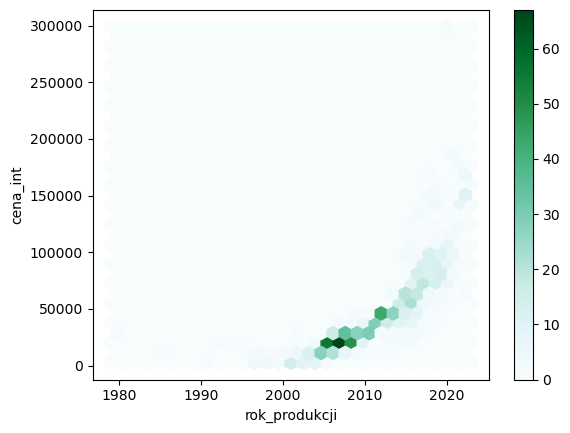

In [234]:
filterhondacivic.plot.hexbin(x="rok_produkcji",y="cena_int",gridsize=30)

# KIA - PROCEED PRICE PLOT

<AxesSubplot:xlabel='rok_produkcji', ylabel='cena_int'>

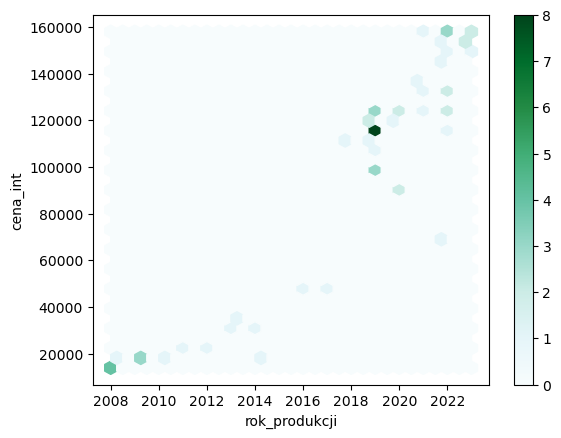

In [235]:
filterkiaproceed.plot.hexbin(x="rok_produkcji",y="cena_int",gridsize=30)

# OPEL - ASTRA PRICE PLOT

<AxesSubplot:xlabel='rok_produkcji', ylabel='cena_int'>

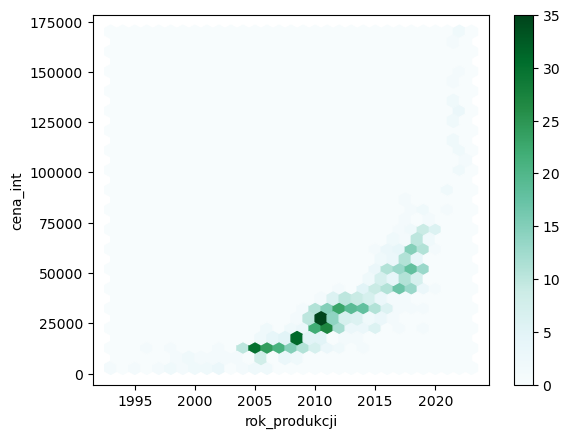

In [236]:
filteropelastra.plot.hexbin(x="rok_produkcji",y="cena_int",gridsize=30)

# Comparing avarege price of astra,golf,civic according to year of production

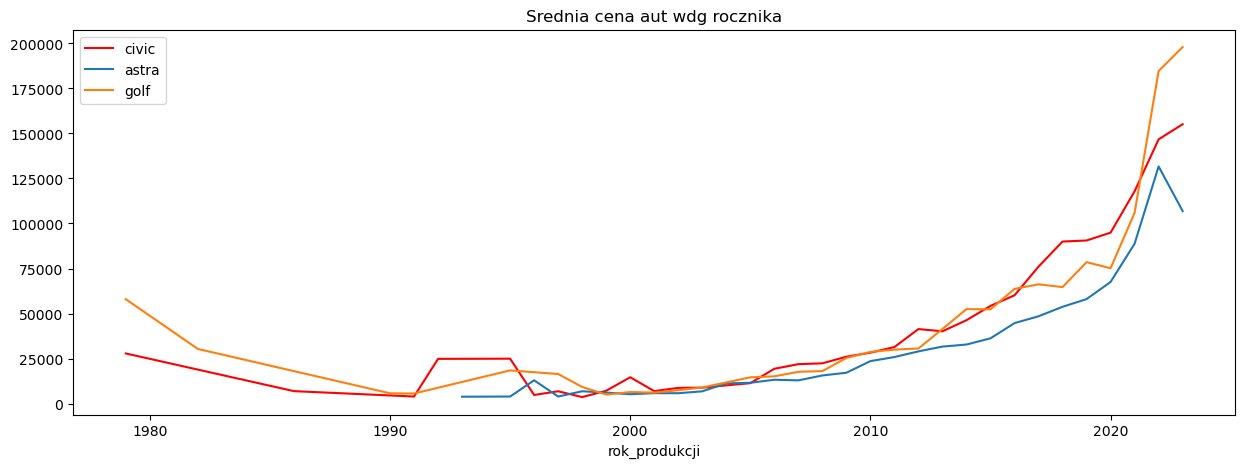

In [297]:
ax = filterhondacivic.groupby('rok_produkcji').mean().plot(figsize=[15,5],title='Srednia cena aut wdg rocznika',colormap='autumn')
filteropelastra.groupby('rok_produkcji').mean().plot(ax=ax)
filtervolkswagengolf.groupby('rok_produkcji').mean().plot(ax=ax)
ax.legend(["civic","astra","golf"])